<a id='top'></a>

# 1) Expected Goals Modeling using Wyscout and StatsBomb Event Data - Creation of the Shot Model (Data Engineering)
##### Notebook to create a 'Shots Model', using publicly available [StatsBomb](https://statsbomb.com/) and [Wyscout](https://wyscout.com/) Event data, to be subsequently used  to create an Expected Goals (xG) model

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/01/2021<br>
Notebook last updated: 18/02/2021

![title](../../../img/expected_goals_visual.png)

Photo credit to David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics?))

---

## <a id='introduction'>Introduction</a>
This notebook is a short walk-through of how to create an Expected Goals (xG) model using a season's worth of [Wyscout](https://wyscout.com/) Event data for the 'Big 5' European leagues, in [Python](https://www.python.org/), using [pandas](http://pandas.pydata.org/) DataFrames, [scikit-learn](https://scikit-learn.org/stable/) and [XGBoost](https://xgboost.readthedocs.io/en/latest/)for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/5_data_analysis_and_projects/xg_modeling/1%29%20Expected%20Goals%20Modeling%20using%20StatsBomb%20and%20Wyscout%20Event%20Data%20-%20Creation%20of%20the%20Shot%20Model%20%28Data%20Engineering%29.ipynb).

___

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Import the Data](#section3.2)<br>
      3.    [Initial Data Handling](#section3.3)<br>   
4.    [Data Engineering](#section4)<br>
      1.    [StatsBomb](#section4.1)<br>
      2.    [Wyscout](#section4.2)<br>
      3.    [Unified Shots Model](#section4.3)<br>
5.    [Exploratory Data Analysis](#section5)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

---

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) for web scraping; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [2]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm    # Progress Bar

# Football libraries
import FCPython
#from FCPython import createPitch
import matplotsoccer

# Machine Learning
import scipy as sp
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
#from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score , roc_curve, average_precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve, plot_calibration_curve
from xgboost import XGBClassifier   # version 1.0.2
import catboost    # pip install catboost if you don't have it
from catboost import CatBoostClassifier, Pool, cv

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [3]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1


### Defined Variables

In [4]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [10]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_sb = os.path.join(base_dir, 'data', 'sb')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
scripts_dir = os.path.join(base_dir, 'scripts')
scripts_dir_sb = os.path.join(base_dir, 'scripts', 'sb')
scripts_dir_wyscout = os.path.join(base_dir, 'scripts', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_sb = os.path.join(base_dir, 'img', 'fig', 'sb')
fig_dir_wyscout = os.path.join(base_dir, 'img', 'fig', 'wyscout')
video_dir = os.path.join(base_dir, 'video')

### Notebook Settings

In [7]:
pd.set_option('display.max_columns', None)

---

## <a id='#section2'>2. Project Brief</a>

### <a id='#section2.1'>2.1. About this notebook</a>
This notebook is the first in a series of notebooks to create an Expected Goals (xG) model using the publicly available Event data from [StatsBomb](https://statsbomb.com/) and [Wyscout](https://wyscout.com/) that includes 67,291 non-penalty shots, using [pandas](http://pandas.pydata.org/) DataFrames, [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

**References**:<br>
*    The StatsBomb data is available from the Open Data repository [[link](https://github.com/statsbomb/open-data)].
*    The Wyscout data is made publicly available in the following paper by Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. **[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)**. In *Scientific Data 6*, no. 1 (2019): 1-15. See data [[link](https://figshare.com/collections/Soccer_match_event_dataset/4415000)].

### <a id='#section2.2'>2.2. What is xG?</a>
["Expected goals"](https://en.wikipedia.org/wiki/Expected_goals) or more commonly known as 'xG', is a derived football metric, which allows you to evaluate team and player performance. In a low-scoring game such as football, final match score does not provide a clear picture of performance. More and more professional clubs and sports analytics teams are now turning to the advanced models like xG, which is a statistical measure of the quality of chances created and conceded.

As a metric, xG assesses every chance, essentially answering the question of whether a player should have scored from a certain opportunity. Put simply, it is a way of assigning a "quality" value (xG) to every attempt based on what we know about it. The higher the xG - with 1 being the maximum - the more likelihood of the opportunity being taken. So if a chance is 0.5xG, it should be scored 50% of the time.

xG was created by [Sam Green](https://twitter.com/aSamGreen) from [Opta](https://www.optasports.com/) after analysing over 300,000 shots to calculate the likelihood of an attempt being scored from a specific position on the pitch during a particular phase of play.

The factors taken into account when assessing the quality of a chance include:
*    Distance from goal
*    Angle of the shot
*    Did the chance fall at the player's feet or was it a header?
*    Was it a one on one?
*    What was the assist like? (eg long ball, cross, through ball, pull-back)
*    In what passage of play did it happen? (eg open play, direct free-kick, corner kick)
*    Has the player just beaten an opponent?
*    Is it a rebound?

The expected goals value reveals a number of things including:
*    Whether a chance really is as good as we think. While football is still a game that where debate and opinion make a huge part of the build up and analysis of matches, using xG we can now say with some certainty whether an opportunity should have been taken.
*    How many goals an individual player should be scoring from the chances their have. A striker might be top of the scoring charts, but does that necessarily mean he is the best finisher in the league? Previously we might have simply looked at their conversion rate (how many of their chances ended up as goals), but this did not provide the whole picture, as someone with a high conversion rate might just be the beneficiary of their team creating really clear-cut chances.
*    Team performance. If a team is performing above or below expectations at the start of the new season, a look at their expected goals difference could tell you whether that run is likely to last.

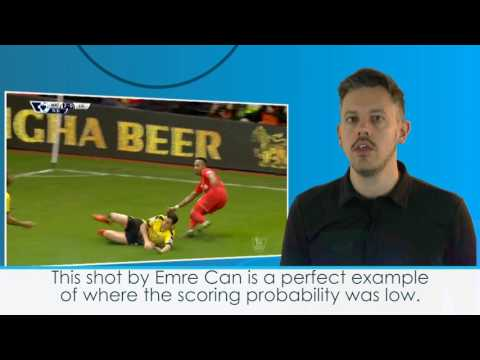

In [8]:
YouTubeVideo('w7zPZsLGK18')

---

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1.'>3.1. Introduction</a>


The data uses publicly available Event data from two data sources:
*    [StatsBomb](https://statsbomb.com/); and
*    [Wyscout](https://wyscout.com/).

#### <a id='#section3.1.1'>3.1.1. StatsBomb</a>

##### <a id='#section3.1.1.1'>3.1.1.1. About StatsBomb</a>
[StatsBomb](https://statsbomb.com/) are a football analytics and data company.

![title](../../../img/stats-bomb-logo.png)

##### <a id='#section3.1.1.2'>3.1.1.2. About the StatsBomb publicly available data</a>
The complete data set contains:
- 7 competitions;
- 879 matches;
- 3,161,917 events;
- z players; and
- 22,007 non-penalty shots

The dataset used in this analysis is a previously engineered version of the Events, matches, and competitions data, merged to one DataFrame.

The data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

#### <a id='#section3.1.2'>3.1.2. Wyscout</a>

##### <a id='#section3.1.2.1'>3.1.2.1. About Wyscout</a>
[Wyscout](https://wyscout.com/) is an Italian company that supports football scouting, match analysis and transfer dynamics. The company was founded in Genoa, Italy in 2004 and provides video analysis tools and digital databases regarding performances and matches for coaches, teams and players dealing with football business.

![title](../../../img/logos/wyscout_logo.png)

The purpose is to allow them have a detailed sight of a large number of athletes about individual performances, patterns of play and tactical strategy.

This notebook explores a complete dataset of event data for the Big 5 European leagues during the 17/18 season.

##### <a id='#section3.1.2.2'>3.1.2.2. About the Wyscout publicly available data</a>
A detailed description of the data can be found in the following paper:
- Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

It is from this paper import the *matches*, *events*, *players*, *playerank*, *referees*, *coaches*, and *competition* data sets from the <a href="https://doi.org/10.6084/m9.figshare.c.4415000.v5">figshare repository</a>. Data are stored in the `JSON` format. 

The complete data set contains:
- 1,941 matches
- 3,251,294 events
- 4,299 players; and
- 45,284 non penalty shots.

The dataset used in this analysis is a previously engineered version of the Events, matches, and competitions data, merged to one DataFrame.

The data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

### <a id='#section3.2'>3.2. Read in Data</a>

####  <a id='#section3.2.1.'>3.2.1. StatsBomb</a>
The following cells read in the engineered CSV data prepared in the following StatsBomb notebooks:
*    [StatsBomb Data Parsing](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/StatsBomb%20Parsing.ipynb); and
*    [StatsBomb Data Engineering](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/StatsBomb%20Data%20Engineering.ipynb).

#####  <a id='#section3.2.2.1.'>3.2.2.1. Data Dictionary</a>

The engineered [StatsBomb](https://statsbomb.com/) dataset has two hundred and seven features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `id`    | `object`
| `index`    | `object`
| `period`    | `object`
| `timestamp`    | `object`
| `minute`    | `object`
| `second`    | `object`
| `possession`    | `object`
| `duration`    | `object`
| `type.id`    | `object`
| `type.name`    | `object`
| `possession_team.id`    | `object`
| `possession_team.name`    | `object`
| `play_pattern.id`    | `object`
| `play_pattern.name`    | `object`
| `team.id`    | `object`
| `team.name`    | `object`
| `tactics.formation`    | `object`
| `tactics.lineup`    | `object`
| `related_events`    | `object`
| `location`    | `object`
| `player.id`    | `object`
| `player.name`    | `object`
| `position.id`    | `object`
| `position.name`    | `object`
| `pass.recipient.id`    | `object`
| `pass.recipient.name`    | `object`
| `pass.length`    | `object`
| `pass.angle`    | `object`
| `pass.height.id`    | `object`
| `pass.height.name`    | `object`
| `pass.end_location`    | `object`
| `pass.type.id`    | `object`
| `pass.type.name`    | `object`
| `pass.body_part.id`    | `object`
| `pass.body_part.name`    | `object`
| `carry.end_location`    | `object`
| `under_pressure`    | `object`
| `duel.type.id`    | `object`
| `duel.type.name`    | `object`
| `out`    | `object`
| `miscontrol.aerial_won`    | `object`
| `pass.outcome.id`    | `object`
| `pass.outcome.name`    | `object`
| `ball_receipt.outcome.id`    | `object`
| `ball_receipt.outcome.name`    | `object`
| `pass.aerial_won`    | `object`
| `counterpress`    | `object`
| `off_camera`    | `object`
| `dribble.outcome.id`    | `object`
| `dribble.outcome.name`    | `object`
| `dribble.overrun`    | `object`
| `ball_recovery.offensive`    | `object`
| `shot.statsbomb_xg`    | `object`
| `shot.end_location`    | `object`
| `shot.outcome.id`    | `object`
| `shot.outcome.name`    | `object`
| `shot.type.id`    | `object`
| `shot.type.name`    | `object`
| `shot.body_part.id`    | `object`
| `shot.body_part.name`    | `object`
| `shot.technique.id`    | `object`
| `shot.technique.name`    | `object`
| `shot.freeze_frame`    | `object`
| `goalkeeper.end_location`    | `object`
| `goalkeeper.type.id`    | `object`
| `goalkeeper.type.name`    | `object`
| `goalkeeper.position.id`    | `object`
| `goalkeeper.position.name`    | `object`
| `pass.straight`    | `object`
| `pass.technique.id`    | `object`
| `pass.technique.name`    | `object`
| `clearance.head`    | `object`
| `clearance.body_part.id`    | `object`
| `clearance.body_part.name`    | `object`
| `pass.switch`    | `object`
| `duel.outcome.id`    | `object`
| `duel.outcome.name`    | `object`
| `foul_committed.advantage`    | `object`
| `foul_won.advantage`    | `object`
| `pass.cross`    | `object`
| `pass.assisted_shot_id`    | `object`
| `pass.shot_assist`    | `object`
| `shot.one_on_one`    | `object`
| `shot.key_pass_id`    | `object`
| `goalkeeper.body_part.id`    | `object`
| `goalkeeper.body_part.name`    | `object`
| `goalkeeper.technique.id`    | `object`
| `goalkeeper.technique.name`    | `object`
| `goalkeeper.outcome.id`    | `object`
| `goalkeeper.outcome.name`    | `object`
| `clearance.aerial_won`    | `object`
| `foul_committed.card.id`    | `object`
| `foul_committed.card.name`    | `object`
| `foul_won.defensive`    | `object`
| `clearance.right_foot`    | `object`
| `shot.first_time`    | `object`
| `pass.through_ball`    | `object`
| `interception.outcome.id`    | `object`
| `interception.outcome.name`    | `object`
| `clearance.left_foot`    | `object`
| `ball_recovery.recovery_failure`    | `object`
| `shot.aerial_won`    | `object`
| `pass.goal_assist`    | `object`
| `pass.cut_back`    | `object`
| `pass.deflected`    | `object`
| `clearance.other`    | `object`
| `pass.outswinging`    | `object`
| `substitution.outcome.id`    | `object`
| `substitution.outcome.name`    | `object`
| `substitution.replacement.id`    | `object`
| `substitution.replacement.name`    | `object`
| `block.deflection`    | `object`
| `block.offensive`    | `object`
| `injury_stoppage.in_chain`    | `object`


Refer to the StatsBomb official documentation for more information [[link](https://statsbomb.com/stat-definitions/)].

#####  <a id='#section3.2.2.2.'>3.2.2.2. Read in CSV as pandas DataFrame</a>

In [16]:
# Show files in directory
print(glob.glob(os.path.join(data_dir_sb, 'events', 'engineered/*')))

['../../../data/sb/events/engineered/sb_events_passing_network_1819_2021_wsl.csv', '../../../data/sb/events/engineered/events_reading_stoke_07112020.csv', '../../../data/sb/events/engineered/events.csv', '../../../data/sb/events/engineered/sb_events_1819_2021_wsl.csv']


In [11]:
# Read in engineered Wyscout Events DataFrame
df_sb = pd.read_csv(os.path.join(data_dir_sb, 'events', 'engineered', 'events.csv'))

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (40,42,50,51,53,54,77,78,79,80,81,86,87,89,96,97,98,99,100,101,102,103,104,106,107,108,109,110,111,112,113,114,120,121,122,123,125,127,128,129,130,131,132,134,136,137,138,139,140,142,143,144,147,148,149,150,159,160,165,169,170,176,177,190) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


####  <a id='#section3.2.2.'>3.2.2. Wyscout</a>
The following cells read in the engineered CSV data prepared in the following Wyscout notebooks:
*    [Wyscout Data Parsing](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/Wyscout%20Parsing.ipynb); and
*    [Wyscout Data Engineering](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Wyscout%20Data%20Engineering.ipynb).

#####  <a id='#section3.2.2.1.'>3.2.2.1. Data Dictionary</a>

The engineered [Wyscout](https://wyscout.com/) Events dataset has sixty features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

#####  <a id='#section3.2.2.1'>3.2.2.1 Read in CSV as pandas DataFrame</a>

In [18]:
# Show files in directory
print(glob.glob(os.path.join(data_dir_wyscout, 'engineered', 'combined/*')))

['../../../data/wyscout/engineered/combined/wyscout_events_big5_1718.csv', '../../../data/wyscout/engineered/combined/wyscout_shots_all_1718.csv', '../../../data/wyscout/engineered/combined/wyscout_aggregated_fixtures_all_1718.csv', '../../../data/wyscout/engineered/combined/wyscout_events_all_1718.csv', '../../../data/wyscout/engineered/combined/spadl', '../../../data/wyscout/engineered/combined/wyscout_aggregated_team_all_1718.csv']


In [19]:
# Read in engineered Wyscout Events DataFrame
df_wyscout = pd.read_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_events_all_1718.csv'))

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### <a id='#section3.3'>3.3. Initial Data Handling</a>

#### <a id='#section3.3.1'>3.3.1. StatsBomb</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [33]:
# Display the first 5 rows of the DataFrame, df_sb
df_sb.head()

,level_0,id,index_x,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_type_id,pass_type_name,pass_body_part_id,pass_body_part_name,carry_end_location,pass_outcome_id,pass_outcome_name,under_pressure,clearance_head,clearance_body_part_id,clearance_body_part_name,counterpress,duel_outcome_id,duel_outcome_name,duel_type_id,duel_type_name,ball_receipt_outcome_id,ball_receipt_outcome_name,out,clearance_left_foot,pass_switch,off_camera,clearance_aerial_won,dribble_outcome_id,dribble_outcome_name,pass_cross,pass_assisted_shot_id,pass_shot_assist,shot_statsbomb_xg,shot_end_location,shot_key_pass_id,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,ball_recovery_recovery_failure,foul_committed_advantage,foul_won_advantage,dribble_overrun,clearance_right_foot,interception_outcome_id,interception_outcome_name,foul_won_defensive,pass_aerial_won,pass_deflected,pass_inswinging,pass_technique_id,pass_technique_name,goalkeeper_body_part_id,goalkeeper_body_part_name,goalkeeper_technique_id,goalkeeper_technique_name,goalkeeper_outcome_id,goalkeeper_outcome_name,pass_outswinging,pass_goal_assist,shot_one_on_one,miscontrol_aerial_won,shot_deflected,block_deflection,shot_first_time,block_offensive,pass_through_ball,foul_committed_card_id,foul_committed_card_name,foul_committed_penalty,foul_won_penalty,dribble_nutmeg,pass_miscommunication,pass_no_touch,foul_committed_offensive,goalkeeper_lost_out,pass_straight,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,match_id,goalkeeper_punched_out,shot_aerial_won,pass_cut_back,goalkeeper_success_in_play,50_50_outcome_id,50_50_outcome_name,foul_committed_type_id,foul_committed_type_name,ball_recovery_offensive,shot_saved_off_target,goalkeeper_shot_saved_off_target,shot_open_goal,dribble_no_touch,bad_behaviour_card_id,bad_behaviour_card_name,half_start_late_video_start,block_save_block,shot_follows_dribble,clearance_other,goalkeeper_shot_saved_to_post,shot_redirect,injury_stoppage_in_chain,shot_saved_to_post,goalkeeper_success_out,goalkeeper_lost_in_play,half_end_early_video_end,player_off_permanent,goalkeeper_saved_to_post,pass_backheel,shot_kick_off,goalkeeper_penalty_saved_to_post,index_y,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,referee,stadium,competition_competition_id,competition_country_name,competition_competition_name,season_season_id,season_season_name,home_team_home_team_id,home_team_home_team_name,home_team_home_team_gender,home_team_home_team_group,home_team_managers,home_team_country_id,home_team_country_name,away_team_away_team_id,away_team_away_team_name,away_team_away_team_gender,away_team_away_team_group,away_team_managers,away_team_country_id,away_team_country_name,metadata_data_version,metadata_shot_fidelity_version,metadata_xy_fidelity_version,competition_stage_id,competition_stage_name,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available,team,opponent,full_fixture_date,location_x,location_y,pass_end_location_x,pass_end_location_y,carry_end_location_x,carry_end_location_y,shot_end_location_x,shot_end_location_y,shot_end_location_z,goalkeeper_end_location_x,goalkeeper_end_location_y
0,4,729957b9-d479-49ab-995f-608a19177be5,5,1,00:00:00.983,0,0,2,1.278634,30,Pass,1,Arsenal,9,From Kick Off,1,Arsenal,NaN,NaN,['1deff0f2-ee63-4951-90ba-f8a8ff399960'],"60.0, 40.0",15512.0,Sylvain Wiltord,22.0,Right

In [34]:
# Display the last 5 rows of the DataFrame, df_sb
df_sb.tail()

,level_0,id,index_x,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_type_id,pass_type_name,pass_body_part_id,pass_body_part_name,carry_end_location,pass_outcome_id,pass_outcome_name,under_pressure,clearance_head,clearance_body_part_id,clearance_body_part_name,counterpress,duel_outcome_id,duel_outcome_name,duel_type_id,duel_type_name,ball_receipt_outcome_id,ball_receipt_outcome_name,out,clearance_left_foot,pass_switch,off_camera,clearance_aerial_won,dribble_outcome_id,dribble_outcome_name,pass_cross,pass_assisted_shot_id,pass_shot_assist,shot_statsbomb_xg,shot_end_location,shot_key_pass_id,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,ball_recovery_recovery_failure,foul_committed_advantage,foul_won_advantage,dribble_overrun,clearance_right_foot,interception_outcome_id,interception_outcome_name,foul_won_defensive,pass_aerial_won,pass_deflected,pass_inswinging,pass_technique_id,pass_technique_name,goalkeeper_body_part_id,goalkeeper_body_part_name,goalkeeper_technique_id,goalkeeper_technique_name,goalkeeper_outcome_id,goalkeeper_outcome_name,pass_outswinging,pass_goal_assist,shot_one_on_one,miscontrol_aerial_won,shot_deflected,block_deflection,shot_first_time,block_offensive,pass_through_ball,foul_committed_card_id,foul_committed_card_name,foul_committed_penalty,foul_won_penalty,dribble_nutmeg,pass_miscommunication,pass_no_touch,foul_committed_offensive,goalkeeper_lost_out,pass_straight,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,match_id,goalkeeper_punched_out,shot_aerial_won,pass_cut_back,goalkeeper_success_in_play,50_50_outcome_id,50_50_outcome_name,foul_committed_type_id,foul_committed_type_name,ball_recovery_offensive,shot_saved_off_target,goalkeeper_shot_saved_off_target,shot_open_goal,dribble_no_touch,bad_behaviour_card_id,bad_behaviour_card_name,half_start_late_video_start,block_save_block,shot_follows_dribble,clearance_other,goalkeeper_shot_saved_to_post,shot_redirect,injury_stoppage_in_chain,shot_saved_to_post,goalkeeper_success_out,goalkeeper_lost_in_play,half_end_early_video_end,player_off_permanent,goalkeeper_saved_to_post,pass_backheel,shot_kick_off,goalkeeper_penalty_saved_to_post,index_y,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,referee,stadium,competition_competition_id,competition_country_name,competition_competition_name,season_season_id,season_season_name,home_team_home_team_id,home_team_home_team_name,home_team_home_team_gender,home_team_home_team_group,home_team_managers,home_team_country_id,home_team_country_name,away_team_away_team_id,away_team_away_team_name,away_team_away_team_gender,away_team_away_team_group,away_team_managers,away_team_country_id,away_team_country_name,metadata_data_version,metadata_shot_fidelity_version,metadata_xy_fidelity_version,competition_stage_id,competition_stage_name,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available,team,opponent,full_fixture_date,location_x,location_y,pass_end_location_x,pass_end_location_y,carry_end_location_x,carry_end_location_y,shot_end_location_x,shot_end_location_y,shot_end_location_z,goalkeeper_end_location_x,goalkeeper_end_location_y
3133317,3971,07a9eed7-0551-4eae-92aa-48b81ce80503,3972,2,00:49:01.532,94,1,166,NaN,42,Ball Receipt*,206,Deportivo Alavés,3,From Free Kick,206,Deportivo Alavés,NaN,NaN,['158c2933-87a2-4b35-bc98-d30daf7870c4'],"80.3

In [35]:
# Print the shape of the raw DataFrame, df_sb
print(df_sb.shape)

(3133322, 207)


In [37]:
# Print the column names of the raw DataFrame, df_sb
print(df_sb.columns)

Index(['level_0', 'id', 'index_x', 'period', 'timestamp', 'minute', 'second',
       'possession', 'duration', 'type_id',
       ...
       'location_y', 'pass_end_location_x', 'pass_end_location_y',
       'carry_end_location_x', 'carry_end_location_y', 'shot_end_location_x',
       'shot_end_location_y', 'shot_end_location_z',
       'goalkeeper_end_location_x', 'goalkeeper_end_location_y'],
      dtype='object', length=207)


The dataset hastwo hundred and seven features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [38]:
# Data types of the features of the DataFrame, df_sb
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_sb.dtypes)

level_0                               int64
id                                   object
index_x                               int64
period                                int64
timestamp                            object
minute                                int64
second                                int64
possession                            int64
duration                            float64
type_id                               int64
type_name                            object
possession_team_id                    int64
possession_team_name                 object
play_pattern_id                       int64
play_pattern_name                    object
team_id                               int64
team_name                            object
tactics_formation                   float64
tactics_lineup                      float64
related_events                       object
location                             object
player_id                           float64
player_name                     

Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [39]:
# Count number of matches in StatsBomb dataset

## Assign number of matches to variable
count_matches_sb = df_sb['match_id'].nunique()

## Print statement 
print(f'The StatsBomb dataset contains {count_matches_sb:,} matches.')

The StatsBomb dataset contains 878 matches.


In [52]:
# Number of matches per competition, per season
df_sb.groupby(['competition_name', 'season_name']).match_id.nunique()

competition_name         season_name
Champions League         2003/2004        1
                         2004/2005        1
                         2006/2007        1
                         2008/2009        1
                         2009/2010        1
                         2010/2011        1
                         2011/2012        1
                         2012/2013        1
                         2013/2014        1
                         2014/2015        1
                         2015/2016        1
                         2016/2017        1
                         2017/2018        1
                         2018/2019        1
FA Women's Super League  2018/2019      107
                         2019/2020       87
FIFA World Cup           2018            64
La Liga                  2004/2005        7
                         2005/2006       17
                         2006/2007       26
                         2007/2008       28
                         2008/2009     

In [53]:
# Info for the DataFrame, df_sb
df_sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3133322 entries, 0 to 3133321
Columns: 207 entries, level_0 to goalkeeper_end_location_y
dtypes: float64(54), int64(24), object(129)
memory usage: 4.8+ GB


In [54]:
# Description of the DataFrame, df_sb, showing some summary statistics for each numberical column in the DataFrame
df_sb.describe()

,level_0,index_x,period,minute,second,possession,duration,type_id,possession_team_id,play_pattern_id,team_id,tactics_formation,tactics_lineup,player_id,position_id,pass_recipient_id,pass_length,pass_angle,pass_height_id,pass_type_id,pass_body_part_id,pass_outcome_id,clearance_body_part_id,duel_outcome_id,duel_type_id,ball_receipt_outcome_id,dribble_outcome_id,shot_statsbomb_xg,shot_body_part_id,shot_technique_id,shot_outcome_id,shot_type_id,goalkeeper_type_id,goalkeeper_position_id,interception_outcome_id,pass_technique_id,goalkeeper_body_part_id,goalkeeper_technique_id,goalkeeper_outcome_id,foul_committed_card_id,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,match_id,50_50_outcome_id,foul_committed_type_id,bad_behaviour_card_id,half_start_late_video_start,injury_stoppage_in_chain,half_end_early_video_end,player_off_permanent,index_y,home_score,away_score,match_week,competition_competition_id,season_season_id,home_team_home_team_id,home_team_country_id,away_team_away_team_id,away_team_country_id,metadata_shot_fidelity_version,metadata_xy_fidelity_version,competition_stage_id,competition_id,season_id,location_x,location_y,pass_end_location_x,pass_end_location_y,carry_end_location_x,carry_end_location_y,shot_end_location_x,shot_end_location_y,shot_end_location_z,goalkeeper_end_location_x,goalkeeper_end_location_y
count,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,2.292933e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,0.0,0.0,3.133297e+06,3.133297e+06,809438.000000,871308.000000,871308.000000,871308.000000,171945.00000,819407.000000,185449.000000,30932.000000,34423.000000,55407.000000,123579.0,36494.000000,22357.000000,22357.000000,22357.000000,22357.000000,22357.000000,26473.000000,22337.000000,16815.000000,10304.000000,6448.000000,8660.000000,12634.000000,2799.000000,0.0,0.0,0.0,0.0,3.133322e+06,1366.000000,1575.000000,628.000000,0.0,0.0,0.0,0.0,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,3.133322e+06,2477616.0,2141127.0,3.133322e+06,3.133322e+06,3.133322e+06,3.132601e+06,3.132601e+06,871308.000000,871308.000000,718104.000000,718104.000000,22357.000000,22357.000000,16179.000000,13784.000000,13784.000000
mean,1.819460e+03,1.820460e+03,1.500028e+00,4.482784e+01,2.937418e+01,9.657993e+01,1.281483e+00,3.242895e+01,4.925945e+02,2.827049e+00,4.971977e+02,NaN,NaN,1.262708e+04,1.123808e+01,12222.931576,21.058518,0.013494,1.555189,65.13010,39.882497,19.264547,38.253136,11.894199,10.621275,9.0,8.381789,0.117009,38.998166,92.906070,98.163394,85.528380,31.258868,43.852532,10.267023,106.536685,36.551179,45.561085,40.609387,6.931404,NaN,NaN,NaN,NaN,4.403372e+05,2.036603,23.274286,6.939490,NaN,NaN,NaN,NaN,2.397274e+01,1.809668e+00,1.436537e+00,1.492901e+01,2.316675e+01,2.208525e+01,5.123709e+02,1.671282e+02,5.096752e+02,1.666331e+02,2.0,2.0,2.556115e+00,2.316675e+01,2.208525e+01,5.933674e+01,4.048626e+01,65.668098,40.457277,62.461544,40.517580,115.937241,39.967849,1.750250,2.411811,40.238762
std,1.075343e+03,1.075343e+03,5.157671e-01,2.710986e+01,1.735328e+01,5.760994e+01,1.387394e+00,1.211835e+01,3.641086e+02,2.199274e+00,3.656117e+02,NaN,NaN,8.831568e+03,7.188297e+00,8679.003819,14.275584,1.542211,0.815164,1.91996,4.434959,24.014366,2.643092,4.937000,0.485074,0.0,0.485832,0.157306,1.999809,0.830046,2.064860,5.919048,6.652252,0.502779,5.258971,1.732251,2.272881,0.496283,20.157284,0.328984,NaN,NaN,NaN,NaN,9.249141e+05,1.179858,1.250034,0.318741,NaN,NaN,NaN,NaN,2.131001e+01,1.694923e+00,1.428751e+00,1.084406e+01,1.808926e+01,1.552450e+01,3.684465e+02,6.941417e+01,3.718400e+02,7.003829e+01,0.0,0.0,5.529304e+00,1.808926e+01,1.552450e+01,2.840339e+01,2.291405e+01,27.297995,23.098104,26.971040,22.777357,6.447794,6.750691,1.721734,4.025187,3.112657
min,4.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-7.398828e+02,2.000000e+00,1.000000e+00,1.000

In [ ]:
"""
# Plot visualisation of the missing values for each feature of the DataFrame, df_sb
msno.matrix(df_sb, figsize = (30, 7))
"""

In [ ]:
# Counts of missing values
null_value_stats = df_sb.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

The visualisation shows us very quickly that there a few missing values in the `value` column, but otherwise the dataset is complete.

#### <a id='#section3.3.2'>3.3.2. Wyscout</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [20]:
# Display the first 5 rows of the DataFrame, df_wyscout
df_wyscout.head()

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,label,date,referees,duration,competitionId,area_name,weight,firstName,middleName,lastName,birthDate,height,foot,shortName,passportArea_name,role_name,birthArea_name,teamName,wyId_y.1,fixture,score_home_away,team_home,team_away,goals_home,goals_away,date_isolated,time_isolated,date_time_isolated,date_time_timestamp,date_date,time_time,full_fixture_date,competition_name,season,fullName,previous_event,teamIdNext,teamNameNext,fullNameNext,player2player,isPossessionRetained
0,8,Simple pass,134351,"[{'y': 50, 'x': 50}, {'y': 57, 'x': 40}]",2499930,Pass,1659,1H,1.914449,85.0,218431699,[{'id': 1801}],Played,4405654,22,181150,2018-01-01 12:30:00,0,The American Express Community Stadium,"Brighton & Hove Albion - AFC Bournemouth, 2 - 2","January 1, 2018 at 1:30:00 PM GMT+1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,England,78,Benik,NaN,Afobe,1993-02-12,183,right,B. Afobe,Congo DR,Forward,England,AFC Bournemouth,1659,Brighton & Hove Albion - AFC Bournemouth,2 - 2,Brighton & Hove Albion,AFC Bournemouth,2,2,"January 1, 2018",1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 12:30:00,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,Premier League,17/18,Benik Afobe,NaN,1659.0,AFC Bournemouth,Lewis Cook,Benik Afobe - Lewis Cook,True
1,8,Simple pass,302518,"[{'y': 57, 'x': 40}, {'y': 12, 'x': 33}]",2499930,Pass,1659,1H,2.784230,85.0,218431700,[{'id': 1801}],Played,4405654,22,181150,2018-01-01 12:30:00,0,The American Express Community Stadium,"Brighton & Hove Albion - AFC Bournemouth, 2 - 2","January 1, 2018 at 1:30:00 PM GMT+1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,England,71,Lewis,NaN,Cook,1997-02-03,175,right,L. Cook,England,Midfielder,England,AFC Bournemouth,1659,Brighton & Hove Albion - AFC Bournemouth,2 - 2,Brighton & Hove Albion,AFC Bournemouth,2,2,"January 1, 2018",1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 12:30:00,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,Premier League,17/18,Lewis Cook,Simple pass,1659.0,AFC Bournemouth,Charlie Daniels,Lewis Cook - Charlie Daniels,True
2,8,Simple pass,9285,"[{'y': 12, 'x': 33}, {'y': 4, 'x': 38}]",2499930,Pass,1659,1H,5.040106,85.0,218431701,[{'id': 1801}],Played,4405654,22,181150,2018-01-01 12:30:00,0,The American Express Community Stadium,"Brighton & Hove Albion - AFC Bournemouth, 2 - 2","January 1, 2018 at 1:30:00 PM GMT+1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,England,75,Charlie,NaN,Daniels,1986-09-07,178,left,C. Daniels,England,Defender,England,AFC Bournemouth,1659,Brighton & Hove Albion - AFC Bournemouth,2 - 2,Brighton & Hove Albion,AFC Bournemouth,2,2,"January 1, 2018",1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 12:30:00,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,Premier League,17/18,Charlie Daniels,Simple pass,1659.0,AFC Bournemouth,Marc Pugh,Charlie Daniels - Marc Pugh,True
3,8,Simple pass,9293,"[{'y': 4, 'x': 38}, {'y': 26, 'x': 41}]",2499930,Pass,1659,1H,6.544869,85.0,218431702,[{'id': 1801}],Played,4405654,22,181150,2018-01-01 12:30:00,0,The American Express Community Stadium,"Brighton & Hove Albion - AFC Bournemouth, 2 - 2","January 1, 2018 at 1:30:00 PM GMT+1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,England,72,Marc,NaN,Pugh,1987-04-02,180,right,M. Pugh,England,Midfielder,England,AFC Bournemouth,1659,Brighton & Hove Albion - AFC Bournemouth,2 - 2,Brighton & Hove Albion,AFC Bournemouth,2,2,"January 1, 2018",1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 12:30:00,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,Premier League,17/18,Marc Pugh,Simple pass,1659.0,AFC Bournemouth,Harry Arter,Marc Pugh - Harry Arter,True
4,8,Simple pass,9283,"[{'y': 26, 'x': 41}, {'y': 10, 'x': 53}]",2499930,Pass,1659,1H,8.24574

In [21]:
# Display the last 5 rows of the DataFrame, df_wyscout
df_wyscout.tail()

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,label,date,referees,duration,competitionId,area_name,weight,firstName,middleName,lastName,birthDate,height,foot,shortName,passportArea_name,role_name,birthArea_name,teamName,wyId_y.1,fixture,score_home_away,team_home,team_away,goals_home,goals_away,date_isolated,time_isolated,date_time_isolated,date_time_timestamp,date_date,time_time,full_fixture_date,competition_name,season,fullName,previous_event,teamIdNext,teamNameNext,fullNameNext,player2player,isPossessionRetained
3025251,8,Launch,8358,"[{'y': 33, 'x': 9}, {'y': 16, 'x': 73}]",2499928,Pass,1627,2H,2934.254686,84.0,218385489,[{'id': 1801}],Played,4405654,21,181150,2017-12-31 16:30:00,0,The Hawthorns,"West Bromwich Albion - Arsenal, 1 - 1","December 31, 2017 at 5:30:00 PM GMT+1","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,England,90,Ben,NaN,Foster,1983-04-03,193,left,B. Foster,England,Goalkeeper,England,West Bromwich Albion,1627,West Bromwich Albion - Arsenal,1 - 1,West Bromwich Albion,Arsenal,1,1,"December 31, 2017",5:30:00 PM GMT+1,"December 31, 2017 5:30:00 PM",2017-12-31 16:30:00,31-12-2017,16:30:00,31-12-2017 West Bromwich Albion 1 v 1 Arsenal,Premier League,17/18,Ben Foster,Simple pass,1609.0,Arsenal,Calum Chambers,Ben Foster - Calum Chambers,False
3025252,1,Ground loose ball duel,171283,"[{'y': 84, 'x': 27}, {'y': 83, 'x': 23}]",2499928,Duel,1609,2H,2937.615034,13.0,218385426,"[{'id': 703}, {'id': 1801}]",Played,4405654,21,181150,2017-12-31 16:30:00,0,The Hawthorns,"West Bromwich Albion - Arsenal, 1 - 1","December 31, 2017 at 5:30:00 PM GMT+1","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,England,66,Calum,NaN,Chambers,1995-01-20,182,right,C. Chambers,England,Defender,England,Arsenal,1609,West Bromwich Albion - Arsenal,1 - 1,West Bromwich Albion,Arsenal,1,1,"December 31, 2017",5:30:00 PM GMT+1,"December 31, 2017 5:30:00 PM",2017-12-31 16:30:00,31-12-2017,16:30:00,31-12-2017 West Bromwich Albion 1 v 1 Arsenal,Premier League,17/18,Calum Chambers,Launch,1627.0,West Bromwich Albion,James McClean,Calum Chambers - James McClean,False
3025253,1,Ground loose ball duel,8530,"[{'y': 16, 'x': 73}, {'y': 17, 'x': 77}]",2499928,Duel,1627,2H,2938.255647,13.0,218385491,"[{'id': 701}, {'id': 1802}]",Played,4405654,21,181150,2017-12-31 16:30:00,0,The Hawthorns,"West Bromwich Albion - Arsenal, 1 - 1","December 31, 2017 at 5:30:00 PM GMT+1","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,England,70,James,NaN,McClean,1989-04-22,180,left,J. McClean,Ireland Republic,Midfielder,Northern Ireland,West Bromwich Albion,1627,West Bromwich Albion - Arsenal,1 - 1,West Bromwich Albion,Arsenal,1,1,"December 31, 2017",5:30:00 PM GMT+1,"December 31, 2017 5:30:00 PM",2017-12-31 16:30:00,31-12-2017,16:30:00,31-12-2017 West Bromwich Albion 1 v 1 Arsenal,Premier League,17/18,James McClean,Ground loose ball duel,1609.0,Arsenal,Calum Chambers,James McClean - Calum Chambers,False
3025254,8,Head pass,171283,"[{'y': 83, 'x': 23}, {'y': 100, 'x': 26}]",2499928,Pass,1609,2H,2939.038529,82.0,218385427,[{'id': 1802}],Played,4405654,21,181150,2017-12-31 16:30:00,0,The Hawthorns,"West Bromwich Albion - Arsenal, 1 - 1","December 31, 2017 at 5:30:00 PM GMT+1","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,England,66,Calum,NaN,Chambers,1995-01-20,182,right,C. Chambers,England,Defender,England,Arsenal,1609,West Bromwich Albion - Arsenal,1 - 1,West Bromwich Albion,Arsenal,1,1,"December 31, 2017",5:30:00 PM GMT+1,"December 31, 2017 5:30:00 PM",2017-12-31 16:30:00,31-12-2017,16:30:00,31-12-2017 West Bromwich Albion 1 v 1 Arsenal,Premier League,17/18,Calum Chambers,Ground loose ball duel,1627.0,West Bromwich Albion,Kieran Gibbs,Calum Chambers - Kieran Gibbs,False
3025255,3,Throw in,7853,"[{'y': 0, 'x': 69}, {'y': 0, 'x': 0}]",2499928,Free Kick,1627,2H,2942.294935,36.0,218385492,[{'id': 1802}],Play

In [22]:
# Print the shape of the DataFrame, df_wyscout
print(df_wyscout.shape)

(3025256, 60)


In [23]:
# Print the column names of the DataFrame, df_wyscout
print(df_wyscout.columns)

Index(['eventId', 'subEventName', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'tags', 'status', 'roundId', 'gameweek', 'seasonId', 'dateutc',
       'winner', 'venue', 'label', 'date', 'referees', 'duration',
       'competitionId', 'area_name', 'weight', 'firstName', 'middleName',
       'lastName', 'birthDate', 'height', 'foot', 'shortName',
       'passportArea_name', 'role_name', 'birthArea_name', 'teamName',
       'wyId_y.1', 'fixture', 'score_home_away', 'team_home', 'team_away',
       'goals_home', 'goals_away', 'date_isolated', 'time_isolated',
       'date_time_isolated', 'date_time_timestamp', 'date_date', 'time_time',
       'full_fixture_date', 'competition_name', 'season', 'fullName',
       'previous_event', 'teamIdNext', 'teamNameNext', 'fullNameNext',
       'player2player', 'isPossessionRetained'],
      dtype='object')


The dataset has fifty nine features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [24]:
# Data types of the features of the DataFrame, df_wyscout
df_wyscout.dtypes

eventId                   int64
subEventName             object
playerId                  int64
positions                object
matchId                   int64
eventName                object
teamId                    int64
matchPeriod              object
eventSec                float64
subEventId              float64
id                        int64
tags                     object
status                   object
roundId                   int64
gameweek                  int64
seasonId                  int64
dateutc                  object
winner                    int64
venue                    object
label                    object
date                     object
referees                 object
duration                 object
competitionId             int64
area_name                object
weight                    int64
firstName                object
middleName              float64
lastName                 object
birthDate                object
height                    int64
foot    

Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [27]:
# Count number of matches in Wyscout dataset

## Assign number of matches to variable
count_matches_wyscout = df_wyscout['matchId'].nunique()

## Print statement 
print(f'The Wyscout dataset contains {count_matches_wyscout:,} matches.')

The Wyscout dataset contains 1,941 matches.


In [49]:
# Number of matches per sompetition, per season
df_wyscout.groupby(['season', 'competition_name']).matchId.nunique()

season  competition_name
17/18   Bundesliga          306
        La Liga             380
        Ligue 1             380
        Premier League      380
        Seria A             380
2016    UEFA EURO 2018       51
2018    FIFA World Cup       64
Name: matchId, dtype: int64

In [29]:
# Info for the DataFrame, df_wyscout
df_wyscout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025256 entries, 0 to 3025255
Data columns (total 60 columns):
 #   Column                Dtype  
---  ------                -----  
 0   eventId               int64  
 1   subEventName          object 
 2   playerId              int64  
 3   positions             object 
 4   matchId               int64  
 5   eventName             object 
 6   teamId                int64  
 7   matchPeriod           object 
 8   eventSec              float64
 9   subEventId            float64
 10  id                    int64  
 11  tags                  object 
 12  status                object 
 13  roundId               int64  
 14  gameweek              int64  
 15  seasonId              int64  
 16  dateutc               object 
 17  winner                int64  
 18  venue                 object 
 19  label                 object 
 20  date                  object 
 21  referees              object 
 22  duration              object 
 23  competi

In [30]:
# Description of the DataFrame, df_wyscout, showing some summary statistics for each numberical column in the DataFrame
df_wyscout.describe()

,eventId,playerId,matchId,teamId,eventSec,subEventId,id,roundId,gameweek,seasonId,winner,competitionId,weight,middleName,height,wyId_y.1,goals_home,teamIdNext
count,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.017102e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,0.0,3.025256e+06,3.025256e+06,3.025256e+06,3.025255e+06
mean,5.694230e+00,8.953778e+04,2.494932e+06,3.004373e+03,1.390728e+03,6.013484e+01,2.158336e+08,4.391560e+06,1.815116e+01,1.709805e+05,2.317237e+03,4.797790e+02,7.622714e+01,NaN,1.820490e+02,3.004373e+03,1.510877e+00,3.004374e+03
std,3.141030e+00,1.169272e+05,1.591746e+05,2.925207e+03,8.347843e+02,3.257763e+01,3.023051e+07,5.686541e+04,1.126545e+01,4.054451e+04,3.021050e+03,1.845044e+02,7.149052e+00,NaN,7.032542e+00,2.925207e+03,1.328161e+00,2.925207e+03
min,1.000000e+00,1.200000e+01,1.694390e+06,6.740000e+02,0.000000e+00,1.000000e+01,8.817864e+07,4.165363e+06,0.000000e+00,9.291000e+03,0.000000e+00,2.800000e+01,0.000000e+00,NaN,0.000000e+00,6.740000e+02,0.000000e+00,6.740000e+02
25%,1.000000e+00,9.380000e+03,2.500086e+06,1.619000e+03,6.608105e+02,1.300000e+01,1.988861e+08,4.405654e+06,8.000000e+00,1.811440e+05,6.740000e+02,3.640000e+02,7.200000e+01,NaN,1.780000e+02,1.619000e+03,1.000000e+00,1.619000e+03
50%,8.000000e+00,2.562300e+04,2.516836e+06,2.460000e+03,1.374896e+03,8.300000e+01,2.191298e+08,4.405655e+06,1.800000e+01,1.811500e+05,1.633000e+03,4.260000e+02,7.600000e+01,NaN,1.820000e+02,2.460000e+03,1.000000e+00,2.460000e+03
75%,8.000000e+00,1.345420e+05,2.565827e+06,3.766000e+03,2.109554e+03,8.500000e+01,2.352463e+08,4.406122e+06,2.800000e+01,1.811890e+05,3.173000e+03,5.240000e+02,8.100000e+01,NaN,1.870000e+02,3.766000e+03,2.000000e+00,3.766000e+03
max,1.000000e+01,5.685830e+05,2.576338e+06,1.983000e+04,3.537356e+03,1.000000e+02,2.802175e+08,4.406278e+06,3.800000e+01,1.812480e+05,1.983000e+04,7.950000e+02,1.010000e+02,NaN,2.030000e+02,1.983000e+04,8.000000e+00,1.983000e+04


<AxesSubplot:>

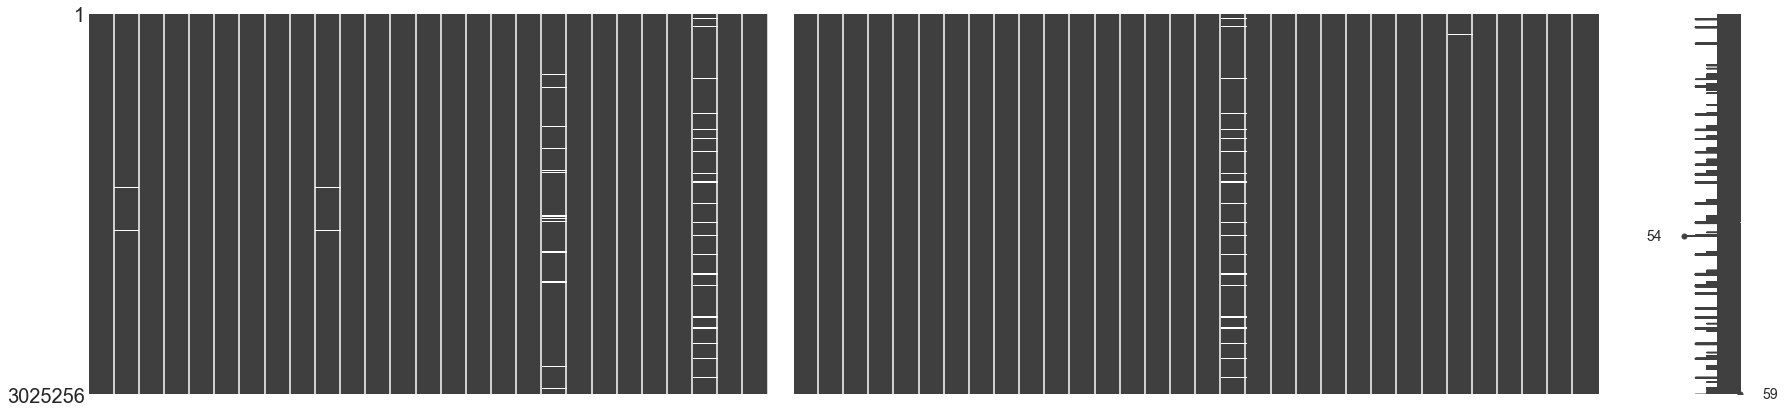

In [31]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_wyscout
msno.matrix(df_wyscout, figsize = (30, 7))

In [32]:
# Counts of missing values
null_value_stats = df_wyscout.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

subEventName         8154
subEventId           8154
venue              166662
area_name          179899
middleName        3025256
foot                  609
time_isolated      179899
previous_event       8155
teamIdNext              1
teamNameNext            1
fullNameNext            1
player2player           1
dtype: int64

The visualisation shows us very quickly that there a few missing values in the `value` column, but otherwise the dataset is complete.

---

## <a id='#section4'>4. Data Engineering</a>
This section creates a 'Shots Model' for each of the two datasets - StatsBomb and Wyscout.

Once these two Shot Models are created, they can then be merged to form one, unified set of shots, and then also compared for overlapping matches, for which there are 100 games.

These 100 matches where there is an overlap are:
- 36 La Liga matches that feature Barcelona (Wyscout all La Liga 17/18 and StatsBomb all Messi matches)
- 64 matches from the FIFA Mens World Cup 2018 (Wyscout and StatsBomb have all these World Cup games)

### <a id='#section4.1'>4.1. StatsBomb</a>

#### <a id='#section4.1.1'>4.1.1. Create Shots-only DataFrame</a>

In [60]:
# Subset only shots from the Events DataFrame
df_sb_shots = df_sb[(df_sb['type_name'] == 'Shot') &
                    (df_sb['shot_type_name'] != 'Penalty')].dropna(how='all', axis=1).copy()

In [64]:
# Count number of matches in Wyscout dataset

## Assign number of matches to variable
count_sb_np_shots = len(df_sb_shots['match_id'])
#count_goals = (df_wsb_shots['subEventName'] == 'Goal').sum()
#percentage_goals = df_sb_shots['goal'].mean()*100


## Print statement 
print(f'Number of non-penalty shots in StatsBomb dataset: {count_sb_np_shots:,}.')
#print(f'Number of goals in StatsBomb dataset: {count_goals:,}.')
#print(f"Expected goal when shooting: {percentage_goals:.2f}%")

Number of non-penalty shots in StatsBomb dataset: 22,007.


##### % Shots belonging to Barcelona

In [65]:
num_barca_shots = ((df_sb.team_name=='Barcelona') & (df_sb.type_name=='Shot')).sum()
num_total_shots = (df_sb.type_name=='Shot').sum()
print('Proportion of shots taken by Barcelona in StatsBomb data:', round(num_barca_shots/num_total_shots * 100, 1))

Proportion of shots taken by Barcelona in StatsBomb data: 34.5


##### Number shots relating to Messi

In [66]:
num_messi_shots = ((df_sb.player_name == 'Lionel Andrés Messi Cuccittini') &
                   (df_sb.type_name == 'Shot')).sum()

In [84]:
print(f'Number of Messi shots in the StatsBomb dataset {num_messi_shots:,}')
print(f'Number of total shots in the StatsBomb dataset {num_total_shots:,}')

Number of Messi shots in the StatsBomb dataset 2,190
Number of total shots in the StatsBomb dataset 22,357


#### <a id='#section4.1.2'>4.1.2. Create Shot-Specific Features Model</a>
Create shot-specific features

In [69]:
df_sb_shots.head(50)

,level_0,id,index_x,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,related_events,location,player_id,player_name,position_id,position_name,under_pressure,out,off_camera,shot_statsbomb_xg,shot_end_location,shot_key_pass_id,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_freeze_frame,shot_one_on_one,shot_deflected,shot_first_time,match_id,shot_aerial_won,shot_saved_off_target,shot_open_goal,shot_follows_dribble,shot_redirect,shot_saved_to_post,shot_kick_off,index_y,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,referee,stadium,competition_competition_id,competition_country_name,competition_competition_name,season_season_id,season_season_name,home_team_home_team_id,home_team_home_team_name,home_team_home_team_gender,home_team_home_team_group,home_team_managers,home_team_country_id,home_team_country_name,away_team_away_team_id,away_team_away_team_name,away_team_away_team_gender,away_team_away_team_group,away_team_managers,away_team_country_id,away_team_country_name,metadata_data_version,metadata_shot_fidelity_version,metadata_xy_fidelity_version,competition_stage_id,competition_stage_name,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available,team,opponent,full_fixture_date,location_x,location_y,shot_end_location_x,shot_end_location_y,shot_end_location_z
174,178,52e9cf2c-e406-48f0-b950-26acbfbf18a8,179,1,00:03:51.134,3,51,9,1.753289,16,Shot,1,Arsenal,1,Regular Play,1,Arsenal,['e92d30d5-dc0a-4c0c-830e-a45076d77f71'],"91.5, 37.1",15512.0,Sylvain Wiltord,22.0,Right Center Forward,NaN,NaN,NaN,0.022911,"120.0, 26.7, 6.2",282abb6d-2f41-46bd-ba22-a411ce0d7a8c,38.0,Left Foot,93.0,Normal,98.0,Off T,87.0,Open Play,"[{'location': [85.1, 52.6], 'player': {'id': 4...",NaN,NaN,NaN,3749493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,2003-08-16,16:00:00.000,2,1,available,2020-07-29T05:00,1,"{'id': 1279, 'name': 'None'}",NaN,2,England,Premier League,44,2003/2004,1,Arsenal,male,NaN,NaN,68,England,29,Everton,male,NaN,NaN,68,England,1.1.0,2.0,2.0,1,Regular Season,2,44,England,Premier League,male,2003/2004,2020-08-31T20:40:28.969635,2020-08-31T20:40:28.969635,Arsenal,Everton,2003-08-16 Arsenal 2 vs. 1 Everton,91.5,37.1,120.0,26.7,6.2
183,187,95f3617d-e00d-4e68-aad3-3566a19583ae,188,1,00:04:23.834,4,23,10,1.786395,16,Shot,29,Everton,7,From Goal Kick,29,Everton,"['650321cc-f4b8-4f43-a9c6-c3f175290901', '84ee...","80.7, 28.4",40289.0,Mark Pembridge,16.0,Left Midfield,True,NaN,NaN,0.006424,"118.6, 42.5, 2.1",NaN,38.0,Left Foot,91.0,Half Volley,100.0,Saved,87.0,Open Play,"[{'location': [81.0, 31.5], 'player': {'id': 4...",NaN,NaN,NaN,3749493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,2003-08-16,16:00:00.000,2,1,available,2020-07-29T05:00,1,"{'id': 1279, 'name': 'None'}",NaN,2,England,Premier League,44,2003/2004,1,Arsenal,male,NaN,NaN,68,England,29,Everton,male,NaN,NaN,68,England,1.1.0,2.0,2.0,1,Regular Season,2,44,England,Premier League,male,2003/2004,2020-08-31T20:40:28.969635,2020-08-31T20:40:28.969635,Everton,Arsenal,2003-08-16 Arsenal 2 vs. 1 Everton,80.7,28.4,118.6,42.5,2.1
273,277,7a82b711-af7e-40c6-b895-3d79e28c7f5f,278,1,00:06:10.511,6,10,16,0.452368,16,Shot,29,Everton,1,Regular Play,29,Everton,['e2445ac4-39cc-44c4-ae48-c3ce3fd51128'],"111.7, 39.3",40283.0,Nick Chadwick,24.0,Left Center Forward,NaN,NaN,NaN,0.277126,"117.5, 42.1, 0.2",3925e6b6-525c-4738-b710-46e47c825ae6,40.0,Right Foot,93.0,Normal,100.0,Saved,87.0,Open Play,"[{'location': [101.9, 32.2], 'player': {'id': ...",NaN,NaN,True,3749493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,2003-08-16,16:00:00.000,2,1,available,2020-07-29T05:00,1,"{'id': 1279, 'name': 'None'}",NaN,2,England,Premier League,44,2003/2004,1,Arsenal,male,NaN,NaN,68,England,29,Everton,male,NaN,NaN,68,England,1.1.0,2.0,2.0,1,Regular Season,2,44,England,Premier Leag

In [71]:
# Define function for whether a shot results in a goal or not
def isGoalFunc(s):
    if s == 'Goal':
        return 1
    else:
        return 0

"""
# Define function for whether a shot comes from a counter attack or not
def isCounterFunc(s):
    if '1901' in s:
        return 1
    else:
        return 0
"""

# Define function for whether a shot comes from the left foot or not
def isLeftFootFunc(s):
    if s == 'Left Foot':
        return 1
    else:
        return 0    
    
# Define function for whether a shot comes from the right foot or not
def isRightFootFunc(s):
    if s == 'Right Foot':
        return 1
    else:
        return 0     

# Define function for whether a shot comes from a counter attack or not
def isHeaderFunc(s):
    if s == 'Head':
        return 1
    else:
        return 0    

In [72]:
df_sb_shots['isGoal'] = df_sb_shots['shot_outcome_name'].apply(isGoalFunc)
#df_sb_shots['isCounter'] = df_sb_shots['tags'].apply(isCounterFunc)
df_sb_shots['isLeftFoot'] = df_sb_shots['shot_body_part_name'].apply(isLeftFootFunc)
df_sb_shots['isRightFoot'] = df_sb_shots['shot_body_part_name'].apply(isRightFootFunc)
df_sb_shots['isHeader'] = df_sb_shots['shot_body_part_name'].apply(isHeaderFunc)

In [ ]:
"""
df_sb_shots['isStrongFoot'] = np.where(((df_sb_shots['isLeftFoot'] == 1) & (df_sb_shots['shot_body_part_name'] == 'Left Foot')) | 
                                       ((df_sb_shots['isRightFoot'] == 1) & (df_sb_shots['shot_body_part_name'] == 'Right Foot')), 1, 0)
"""

In [74]:
df_sb_shots.head(3)

,level_0,id,index_x,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,related_events,location,player_id,player_name,position_id,position_name,under_pressure,out,off_camera,shot_statsbomb_xg,shot_end_location,shot_key_pass_id,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_freeze_frame,shot_one_on_one,shot_deflected,shot_first_time,match_id,shot_aerial_won,shot_saved_off_target,shot_open_goal,shot_follows_dribble,shot_redirect,shot_saved_to_post,shot_kick_off,index_y,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,referee,stadium,competition_competition_id,competition_country_name,competition_competition_name,season_season_id,season_season_name,home_team_home_team_id,home_team_home_team_name,home_team_home_team_gender,home_team_home_team_group,home_team_managers,home_team_country_id,home_team_country_name,away_team_away_team_id,away_team_away_team_name,away_team_away_team_gender,away_team_away_team_group,away_team_managers,away_team_country_id,away_team_country_name,metadata_data_version,metadata_shot_fidelity_version,metadata_xy_fidelity_version,competition_stage_id,competition_stage_name,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available,team,opponent,full_fixture_date,location_x,location_y,shot_end_location_x,shot_end_location_y,shot_end_location_z,isGoal,isLeftFoot,isRightFoot,isHeader
174,178,52e9cf2c-e406-48f0-b950-26acbfbf18a8,179,1,00:03:51.134,3,51,9,1.753289,16,Shot,1,Arsenal,1,Regular Play,1,Arsenal,['e92d30d5-dc0a-4c0c-830e-a45076d77f71'],"91.5, 37.1",15512.0,Sylvain Wiltord,22.0,Right Center Forward,NaN,NaN,NaN,0.022911,"120.0, 26.7, 6.2",282abb6d-2f41-46bd-ba22-a411ce0d7a8c,38.0,Left Foot,93.0,Normal,98.0,Off T,87.0,Open Play,"[{'location': [85.1, 52.6], 'player': {'id': 4...",NaN,NaN,NaN,3749493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,2003-08-16,16:00:00.000,2,1,available,2020-07-29T05:00,1,"{'id': 1279, 'name': 'None'}",NaN,2,England,Premier League,44,2003/2004,1,Arsenal,male,NaN,NaN,68,England,29,Everton,male,NaN,NaN,68,England,1.1.0,2.0,2.0,1,Regular Season,2,44,England,Premier League,male,2003/2004,2020-08-31T20:40:28.969635,2020-08-31T20:40:28.969635,Arsenal,Everton,2003-08-16 Arsenal 2 vs. 1 Everton,91.5,37.1,120.0,26.7,6.2,0,1,0,0
183,187,95f3617d-e00d-4e68-aad3-3566a19583ae,188,1,00:04:23.834,4,23,10,1.786395,16,Shot,29,Everton,7,From Goal Kick,29,Everton,"['650321cc-f4b8-4f43-a9c6-c3f175290901', '84ee...","80.7, 28.4",40289.0,Mark Pembridge,16.0,Left Midfield,True,NaN,NaN,0.006424,"118.6, 42.5, 2.1",NaN,38.0,Left Foot,91.0,Half Volley,100.0,Saved,87.0,Open Play,"[{'location': [81.0, 31.5], 'player': {'id': 4...",NaN,NaN,NaN,3749493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,2003-08-16,16:00:00.000,2,1,available,2020-07-29T05:00,1,"{'id': 1279, 'name': 'None'}",NaN,2,England,Premier League,44,2003/2004,1,Arsenal,male,NaN,NaN,68,England,29,Everton,male,NaN,NaN,68,England,1.1.0,2.0,2.0,1,Regular Season,2,44,England,Premier League,male,2003/2004,2020-08-31T20:40:28.969635,2020-08-31T20:40:28.969635,Everton,Arsenal,2003-08-16 Arsenal 2 vs. 1 Everton,80.7,28.4,118.6,42.5,2.1,0,1,0,0
273,277,7a82b711-af7e-40c6-b895-3d79e28c7f5f,278,1,00:06:10.511,6,10,16,0.452368,16,Shot,29,Everton,1,Regular Play,29,Everton,['e2445ac4-39cc-44c4-ae48-c3ce3fd51128'],"111.7, 39.3",40283.0,Nick Chadwick,24.0,Left Center Forward,NaN,NaN,NaN,0.277126,"117.5, 42.1, 0.2",3925e6b6-525c-4738-b710-46e47c825ae6,40.0,Right Foot,93.0,Normal,100.0,Saved,87.0,Open Play,"[{'location': [101.9, 32.2], 'player': {'id': ...",NaN,NaN,True,3749493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,2003-08-16,16:00:00.000,2,1,available,2020-07-29T05:00,1,"{'id': 1279, 'name': 'None'}",NaN,2,England,Premier League,44,2003/2004,1,Arsenal,male,NaN,NaN,68,England,29,Everton,male,NaN,NaN,68,England,1

#### <a id='#section4.1.3'>4.1.3. Create Shot Model</a>
Creation of the Open Player Shots Model from the Events data.

The following code to determine the angle and distance of a goal is taken from the lecture by David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics)). To find out more, see the lecture [[link](https://www.youtube.com/watch?v=bpjLyFyLlXs)] and code [[link](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py)].

In [76]:
# Select columns of interest
cols = ['location_x',
        'location_y',
       #'isLeftFoot',
       #'isRightFoot',
       #'isHeader',
       #'isCounter',
       #'isStrongFoot'
       ]

# Create more concise DataFrame using only columns of interest
sb_shots_model = df_sb_shots[cols]

sb_shots_model['side_of_field'] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
sb_shots_model.head(3)

,location_x,location_y,side_of_field
174,91.5,37.1,0
183,80.7,28.4,0
273,111.7,39.3,0


In [79]:
# Go through the dataframe and calculate X, Y co-ordinates.
# Distance from a line in the centre
# Shot angle.
# Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events

## 
for i, shot in df_sb_shots.iterrows():
    sb_shots_model.at[i, 'x'] = 100 - shot['location_x']
    sb_shots_model.at[i, 'y'] = shot['location_y']
    sb_shots_model.at[i, 'side_of_field'] = 1 * (shot['location_y'] < 50)
    sb_shots_model.at[i, 'c'] = abs(shot['location_y'] - 50)

    # Distance in metres and shot angle in radians.
    x = sb_shots_model.at[i, 'x'] * 105 / 100
    y = sb_shots_model.at[i, 'c']  *65 / 100
    sb_shots_model.at[i, 'distance'] = np.sqrt(x**2 + y**2)
    a = np.arctan(7.32 *x / (x**2 + y**2 - (7.32/2)**2))
    if a < 0:
        a = np.pi + a
    sb_shots_model.at[i, 'angle'] = a

# Fill N/A values with 0        
sb_shots_model = sb_shots_model.fillna(0)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [80]:
sb_shots_model

,location_x,location_y,side_of_field,x,y,c,distance,angle
174,91.5,37.1,1,8.5,37.1,12.9,12.245973,0.446199
183,80.7,28.4,1,19.3,28.4,21.6,24.653434,0.244568
273,111.7,39.3,1,-11.7,39.3,10.7,14.117126,2.691037
277,109.8,23.9,1,-9.8,23.9,26.1,19.841757,2.946062
367,92.5,11.9,1,7.5,11.9,38.1,25.986936,0.086868
...,...,...,...,...,...,...,...,...
3132909,102.7,43.8,1,-2.7,43.8,6.2,4.927284,2.053776
3132969,105.6,22.9,1,-5.6,22.9,27.1,18.570477,3.012463
3133149,113.6,28.6,1,-13.6,28.6,21.4,19.935057,2.875827
3133152,118.9,45.3,1,-18.9,45.3,4.7,20.078771,2.784837


In [81]:
df_sb_shots_merge = pd.merge(sb_shots_model, df_sb_shots, left_index=True, right_index=True, how='left')
df_sb_shots_merge = df_sb_shots_merge.reset_index(drop=True)

In [82]:
# Print the shape of the DataFrame, df_sb_shots_merge
print(df_sb_shots_merge.shape)

(22007, 111)


#### <a id='#section4.1.4'>4.1.4. Streamline DataFrames</a>
Streamline both Events and Shots DataFrames

##### Shots DataFrame

In [ ]:
# Select columns of interest
cols = ['id',
        'matchPeriod',
        'eventSec',
        'x',
        'y',
        'c',
        'distance',
        'angle',
        'isGoal',
        'isCounter',
        'isLeftFoot',
        'isRightFoot',
        'isHeader',
        'isStrongFoot',
        'side_of_field',
        'x_before_x',
        'y_before_x',
        'y_after',
        'x_after',
        'eventName',
        'subEventName',
        'previous_event',
        'fullName',
        'role_name',
        'birthDate',
        'height',
        'foot',
        'season',
        'competition_name',
        'winner',
        'venue',
        'duration',
        'birthArea_name',
        'teamName',
        'fixture',
        'team_home',
        'team_away',
        'score_home_away',
        'goals_home',
        'goals_away',
        'date_date',
        'time_time',
        'full_fixture_date',
       ]

# Create more concise DataFrame using only columns of interest
df_sb_shots_merge_select = df_sb_shots_merge[cols]

In [ ]:
# Rename some columns
df_sb_shots_merge_select = df_sb_shots_merge_select.rename(columns={'id': 'event_id',
                                                                    'match_period': 'half',
                                                                    'x_before_x':'x_before',
                                                                    'y_before_x': 'y_before',
                                                                    'eventName': 'event_name',
                                                                    'subEventName': 'sub_event_name',
                                                                    'fullName': 'full_name',
                                                                    'birthDate': 'birth_date',
                                                                    'birthArea_name': 'cob',
                                                                    'teamName': 'team',
                                                                    'date_date': 'date',
                                                                    'time_time': 'time'
                                                                   }
                                                          )

In [ ]:
df_sb_shots_merge_select.head(3)

##### All Events DataFrame

### <a id='#section4.2'>4.2. Wyscout</a>

#### <a id='#section4.2.1'>4.2.1. Create Shots-only DataFrame</a>

In [83]:
# Subset only shots from the Events DataFrame
df_wyscout_shots = df_wyscout[((df_wyscout['eventName'] == 'Shot') |
                               (df_wyscout['subEventName'] == 'Free kick shot')
                              ) &
                               (df_wyscout['matchPeriod']!='P')
                             ].copy()

"""
# Subset 2 - not used

# In this example, only including shots, not freekicks. 
df_wyscout_shots = df_wyscout[(df_wyscout['subEventName'] == 'Shot') |
                              (df_wyscout['subEventName'] == 'Free kick shot')
                             ].copy()

# Subset 3 - not used

df_shots = df_wyscout[(df_wyscout['subEventName'] == 'Shot')].copy()
"""

"\n# Subset 2 - not used\n\n# In this example, only including shots, not freekicks. \ndf_wyscout_shots = df_wyscout[(df_wyscout['subEventName'] == 'Shot') |\n                              (df_wyscout['subEventName'] == 'Free kick shot')\n                             ].copy()\n\n# Subset 3 - not used\n\ndf_shots = df_wyscout[(df_wyscout['subEventName'] == 'Shot')].copy()\n"

In [291]:
# Count number of matches in Wyscout dataset

## Assign number of matches to variable
count_np_shots = len(df_wyscout_shots['matchId'])
#count_goals = (df_wyscout_shots['subEventName'] == 'Goal').sum()
#percentage_goals = df_wyscout_shots['goal'].mean()*100


## Print statement 
print(f'Number of non-penalty shots in Wyscout dataset: {count_np_shots:,}.')
#print(f'Number of goals in Wyscout dataset: {count_goals:,}.')
#print(f"Expected goal when shooting: {percentage_goals:.2f}%")

Number of non-penalty shots in Wyscout dataset: 45,284.


#### <a id='#section4.2.2'>4.2.2. Create Shot-Specific Features Model</a>
Create shot-specific features

In [292]:
df_wyscout_shots['positions'] = df_wyscout_shots['positions'].str.replace('[','')
df_wyscout_shots['positions'] = df_wyscout_shots['positions'].str.replace(']','')
df_wyscout_shots['positions'] = df_wyscout_shots['positions'].str.replace('}, {',', ')
df_wyscout_shots['positions'] = df_wyscout_shots['positions'].str.replace("{\'y\': ", "")
df_wyscout_shots['positions'] = df_wyscout_shots['positions'].str.replace(", 'x': ", ", ")
df_wyscout_shots['positions'] = df_wyscout_shots['positions'].str.replace(", 'y':", ", ")
df_wyscout_shots['positions'] = df_wyscout_shots['positions'].str.replace("}", "")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  a

In [293]:
df_wyscout_shots[['y_before', 'x_before', 'y_after', 'x_after']] = df_wyscout_shots['positions'].str.split(',', expand=True)

In [294]:
df_wyscout_shots['y_before'] = df_wyscout_shots['y_before'].astype('float64')
df_wyscout_shots['x_before'] = df_wyscout_shots['x_before'].astype('float64')
df_wyscout_shots['y_after'] = df_wyscout_shots['y_after'].astype('float64')
df_wyscout_shots['x_after'] = df_wyscout_shots['x_after'].astype('float64')

In [295]:
# Define function for whether a shot results in a goal or not
def isGoalFunc(s):
    if '101' in s:
        return 1
    else:
        return 0
    
# Define function for whether a shot comes from a counter attack or not
def isCounterFunc(s):
    if '1901' in s:
        return 1
    else:
        return 0

# Define function for whether a shot comes from the left foot or not
def isLeftFootFunc(s):
    if '401' in s:
        return 1
    else:
        return 0    
    
# Define function for whether a shot comes from the right foot or not
def isRightFootFunc(s):
    if '402' in s:
        return 1
    else:
        return 0   

# Define function for whether a shot comes from a counter attack or not
def isHeaderFunc(s):
    if '403' in s:
        return 1
    else:
        return 0

In [296]:
df_wyscout_shots['isGoal'] = df_wyscout_shots['tags'].apply(isGoalFunc)
df_wyscout_shots['isCounter'] = df_wyscout_shots['tags'].apply(isCounterFunc)
df_wyscout_shots['isLeftFoot'] = df_wyscout_shots['tags'].apply(isLeftFootFunc)
df_wyscout_shots['isRightFoot'] = df_wyscout_shots['tags'].apply(isRightFootFunc)
df_wyscout_shots['isHeader'] = df_wyscout_shots['tags'].apply(isHeaderFunc)

In [297]:
df_wyscout_shots['isStrongFoot'] = np.where(((df_wyscout_shots['isLeftFoot'] == 1) & (df_wyscout_shots['foot'] == 'left')) | 
                                            ((df_wyscout_shots['isRightFoot'] == 1) & (df_wyscout_shots['foot'] == 'right')), 1, 0)

In [298]:
df_wyscout_shots.head(3)

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,label,date,referees,duration,competitionId,area_name,weight,firstName,middleName,lastName,birthDate,height,foot,shortName,passportArea_name,role_name,birthArea_name,teamName,wyId_y.1,fixture,score_home_away,team_home,team_away,goals_home,goals_away,date_isolated,time_isolated,date_time_isolated,date_time_timestamp,date_date,time_time,full_fixture_date,competition_name,season,fullName,previous_event,teamIdNext,teamNameNext,fullNameNext,player2player,isPossessionRetained,y_before,x_before,y_after,x_after,isGoal,isCounter,isLeftFoot,isRightFoot,isHeader,isStrongFoot
90,10,Shot,25950,"62, 97, 0, 0",2499930,Shot,1651,1H,274.719322,100.0,218431851,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",Played,4405654,22,181150,2018-01-01 12:30:00,0,The American Express Community Stadium,"Brighton & Hove Albion - AFC Bournemouth, 2 - 2","January 1, 2018 at 1:30:00 PM GMT+1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,England,69,Anthony,NaN,Knockaert,1991-11-20,172,left,A. Knockaert,Belgium,Midfielder,France,Brighton & Hove Albion,1651,Brighton & Hove Albion - AFC Bournemouth,2 - 2,Brighton & Hove Albion,AFC Bournemouth,2,2,"January 1, 2018",1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 12:30:00,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,Premier League,17/18,Anthony Knockaert,Cross,1659.0,AFC Bournemouth,Asmir Begović,Anthony Knockaert - Asmir Begović,False,62.0,97.0,0.0,0.0,1,0,0,1,0,0
148,10,Shot,91381,"25, 76, 0, 0",2499930,Shot,1651,1H,508.523125,100.0,218431937,"[{'id': 402}, {'id': 201}, {'id': 1213}, {'id'...",Played,4405654,22,181150,2018-01-01 12:30:00,0,The American Express Community Stadium,"Brighton & Hove Albion - AFC Bournemouth, 2 - 2","January 1, 2018 at 1:30:00 PM GMT+1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,England,75,José Heriberto,NaN,Izquierdo Mena,1992-07-07,171,right,J. Izquierdo,Colombia,Forward,Colombia,Brighton & Hove Albion,1651,Brighton & Hove Albion - AFC Bournemouth,2 - 2,Brighton & Hove Albion,AFC Bournemouth,2,2,"January 1, 2018",1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 12:30:00,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,Premier League,17/18,José Heriberto Izquierdo Mena,Ground defending duel,1659.0,AFC Bournemouth,Asmir Begović,José Heriberto Izquierdo Mena - Asmir Begović,False,25.0,76.0,0.0,0.0,0,0,0,1,0,1
197,10,Shot,11669,"40, 89, 100, 100",2499930,Shot,1659,1H,698.486166,100.0,218431908,"[{'id': 401}, {'id': 201}, {'id': 1210}, {'id'...",Played,4405654,22,181150,2018-01-01 12:30:00,0,The American Express Community Stadium,"Brighton & Hove Albion - AFC Bournemouth, 2 - 2","January 1, 2018 at 1:30:00 PM GMT+1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,England,66,Callum,NaN,Wilson,1992-02-27,180,right,C. Wilson,Ireland Republic,Forward,England,AFC Bournemouth,1659,Brighton & Hove Albion - AFC Bournemouth,2 - 2,Brighton & Hove Albion,AFC Bournemouth,2,2,"January 1, 2018",1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 12:30:00,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,Premier League,17/18,Callum Wilson,Smart pass,1651.0,Brighton & Hove Albion,Mathew Ryan,Callum Wilson - Mathew Ryan,False,40.0,89.0,100.0,100.0,0,0,1,0,0,0


#### <a id='#section4.2.3'>4.2.3. Create Shot Model</a>
Creation of the Open Player Shots Model from the Events data.

The following code to determine the angle and distance of a goal is taken from the lecture by David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics)). To find out more, see the lecture [[link](https://www.youtube.com/watch?v=bpjLyFyLlXs)] and code [[link](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py)].

In [299]:
# Select columns of interest
cols = ['x_before',
        'y_before',
       #'isLeftFoot',
       #'isRightFoot',
       #'isHeader',
       #'isCounter',
       #'isStrongFoot'
       ]

# Create more concise DataFrame using only columns of interest
shots_model = df_wyscout_shots[cols]

shots_model['side_of_field'] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,x_before,y_before,side_of_field
90,97.0,62.0,0
148,76.0,25.0,0
197,89.0,40.0,0


In [300]:
shots_model.head(3)

,x_before,y_before,side_of_field
90,97.0,62.0,0
148,76.0,25.0,0
197,89.0,40.0,0


In [301]:
# Go through the dataframe and calculate X, Y co-ordinates.
# Distance from a line in the centre
# Shot angle.
# Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events

## 
for i, shot in df_wyscout_shots.iterrows():
    shots_model.at[i, 'x'] = 100 - shot['x_before']
    shots_model.at[i, 'y'] = shot['y_before']
    shots_model.at[i, 'side_of_field'] = 1 * (shot['y_before'] < 50)
    shots_model.at[i, 'c'] = abs(shot['y_before'] - 50)

    # Distance in metres and shot angle in radians.
    x = shots_model.at[i, 'x'] * 105 / 100
    y = shots_model.at[i, 'c']  *65 / 100
    shots_model.at[i, 'distance'] = np.sqrt(x**2 + y**2)
    a = np.arctan(7.32 *x / (x**2 + y**2 - (7.32/2)**2))
    if a < 0:
        a = np.pi + a
    shots_model.at[i, 'angle'] = a

# Fill N/A values with 0        
shots_model = shots_model.fillna(0)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [304]:
df_wyscout_shots_merge = pd.merge(shots_model, df_wyscout_shots, left_index=True, right_index=True, how='left')
df_wyscout_shots_merge = df_wyscout_shots_merge.reset_index(drop=True)

In [305]:
# Print the shape of the DataFrame, df_wyscout_shots_merge
print(df_wyscout_shots_merge.shape)

(45284, 78)


#### <a id='#section4.2.4'>4.2.4. Streamline DataFrames</a>
Streamline both Events and Shots DataFrames

##### Shots DataFrame

In [328]:
# Select columns of interest
cols = ['id',
        'matchPeriod',
        'eventSec',
        'x',
        'y',
        'c',
        'distance',
        'angle',
        'isGoal',
        'isCounter',
        'isLeftFoot',
        'isRightFoot',
        'isHeader',
        'isStrongFoot',
        'side_of_field',
        'x_before_x',
        'y_before_x',
        'y_after',
        'x_after',
        'eventName',
        'subEventName',
        'previous_event',
        'fullName',
        'role_name',
        'birthDate',
        'height',
        'foot',
        'season',
        'competition_name',
        'winner',
        'venue',
        'duration',
        'birthArea_name',
        'teamName',
        'fixture',
        'team_home',
        'team_away',
        'score_home_away',
        'goals_home',
        'goals_away',
        'date_date',
        'time_time',
        'full_fixture_date',
       ]

# Create more concise DataFrame using only columns of interest
df_wyscout_shots_merge_select = df_wyscout_shots_merge[cols]

In [333]:
# Rename some columns
df_wyscout_shots_merge_select = df_wyscout_shots_merge_select.rename(columns={'id': 'event_id',
                                                                              'match_period': 'half',
                                                                              'x_before_x':'x_before',
                                                                              'y_before_x': 'y_before',
                                                                              'eventName': 'event_name',
                                                                              'subEventName': 'sub_event_name',
                                                                              'fullName': 'full_name',
                                                                              'birthDate': 'birth_date',
                                                                              'birthArea_name': 'cob',
                                                                              'teamName': 'team',
                                                                              'date_date': 'date',
                                                                              'time_time': 'time'
                                                                             }
                                                                    )

In [334]:
df_wyscout_shots_merge_select.head(3)

,event_id,matchPeriod,eventSec,x,y,c,distance,angle,isGoal,isCounter,isLeftFoot,isRightFoot,isHeader,isStrongFoot,side_of_field,x_before,y_before,y_after,x_after,eventId,event_name,sub_event_name,previous_event,full_name,role_name,birth_date,height,foot,season,competition_name,winner,venue,duration,cob,team,fixture,team_home,team_away,score_home_away,goals_home,goals_away,date,time,full_fixture_date
0,218431851,1H,274.719322,3.0,62.0,12.0,8.412045,0.382177,1,0,0,1,0,0,0,97.0,62.0,0.0,0.0,10,Shot,Shot,Cross,Anthony Knockaert,Midfielder,1991-11-20,172,left,17/18,Premier League,0,The American Express Community Stadium,Regular,France,Brighton & Hove Albion,Brighton & Hove Albion - AFC Bournemouth,Brighton & Hove Albion,AFC Bournemouth,2 - 2,2,2,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...
1,218431937,1H,508.523125,24.0,25.0,25.0,29.985038,0.205332,0,0,0,1,0,1,1,76.0,25.0,0.0,0.0,10,Shot,Shot,Ground defending duel,José Heriberto Izquierdo Mena,Forward,1992-07-07,171,right,17/18,Premier League,0,The American Express Community Stadium,Regular,Colombia,Brighton & Hove Albion,Brighton & Hove Albion - AFC Bournemouth,Brighton & Hove Albion,AFC Bournemouth,2 - 2,2,2,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...
2,218431908,1H,698.486166,11.0,40.0,10.0,13.253396,0.480355,0,0,1,0,0,0,1,89.0,40.0,100.0,100.0,10,Shot,Shot,Smart pass,Callum Wilson,Forward,1992-02-27,180,right,17/18,Premier League,0,The American Express Community Stadium,Regular,England,AFC Bournemouth,Brighton & Hove Albion - AFC Bournemouth,Brighton & Hove Albion,AFC Bournemouth,2 - 2,2,2,01-01-2018,12:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...


##### All Events DataFrame

In [335]:
# Select columns of interest
cols = ['id',
        'matchPeriod',
        'eventSec',
       #'x_before',
       #'y_before',
       #'y_after',
       #'x_after',
        'eventName',
        'subEventName',
        'previous_event',
        'fullName',
        'role_name',
        'birthDate',
        'height',
        'foot',
        'season',
        'competition_name',
        'winner',
        'venue',
        'duration',
        'birthArea_name',
        'teamName',
        'fixture',
        'team_home',
        'team_away',
        'score_home_away',
        'goals_home',
        'goals_away',
        'date_date',
        'time_time',
        'full_fixture_date',
       ]

# Create more concise DataFrame using only columns of interest
df_wyscout_events_select = df_wyscout[cols]

#### <a id='#section4.2.5'>4.2.5. Quality Checks of Shots</a>

In [311]:
df_wyscout_shots_merge.loc[df_wyscout_shots_merge['id'] == 88178722]

,x_before_x,y_before_x,side_of_field,x,y,c,distance,angle,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,label,date,referees,duration,competitionId,area_name,weight,firstName,middleName,lastName,birthDate,height,foot,shortName,passportArea_name,role_name,birthArea_name,teamName,wyId_y.1,fixture,score_home_away,team_home,team_away,goals_home,goals_away,date_isolated,time_isolated,date_time_isolated,date_time_timestamp,date_date,time_time,full_fixture_date,competition_name,season,fullName,previous_event,teamIdNext,teamNameNext,fullNameNext,player2player,isPossessionRetained,y_before_y,x_before_y,y_after,x_after,isGoal,isCounter,isLeftFoot,isRightFoot,isHeader,isStrongFoot
11977,71.0,29.0,1,29.0,29.0,21.0,33.369522,0.199901,10,Shot,83824,"29, 71, 100, 100",1694390,Shot,11944,1H,143.119551,100.0,88178722,"[{'id': 402}, {'id': 201}, {'id': 1216}, {'id'...",Played,4165470,1,9291,2016-06-10 19:00:00,4418,Stade de France,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,NaN,78,Mihai Doru,NaN,Pintilii,1984-11-09,180,right,M. Pintilii,Romania,Midfielder,Romania,Romania,11944,France - Romania,2 - 1,France,Romania,2,1,2016-06-10 21:00:00-02:00,NaN,2016-06-10 21:00:00-02:00,2016-06-10 19:00:00,10-06-2016,19:00:00,10-06-2016 France 2 v 1 Romania,UEFA EURO 2018,2016,Mihai Doru Pintilii,Simple pass,4418.0,France,Hugo Lloris,Mihai Doru Pintilii - Hugo Lloris,False,29.0,71.0,100.0,100.0,0,0,0,1,0,1


In [314]:
df_wyscout_shots_merge.loc[(df_wyscout_shots_merge['isLeftFoot'] == 1) & (df_wyscout_shots_merge['isRightFoot'] == 1)]

,x_before_x,y_before_x,side_of_field,x,y,c,distance,angle,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,label,date,referees,duration,competitionId,area_name,weight,firstName,middleName,lastName,birthDate,height,foot,shortName,passportArea_name,role_name,birthArea_name,teamName,wyId_y.1,fixture,score_home_away,team_home,team_away,goals_home,goals_away,date_isolated,time_isolated,date_time_isolated,date_time_timestamp,date_date,time_time,full_fixture_date,competition_name,season,fullName,previous_event,teamIdNext,teamNameNext,fullNameNext,player2player,isPossessionRetained,y_before_y,x_before_y,y_after,x_after,isGoal,isCounter,isLeftFoot,isRightFoot,isHeader,isStrongFoot
69,87.0,40.0,1,13.0,40.0,10.0,15.118614,0.434725,10,Shot,265366,"40, 87, 0, 0",2499933,Shot,1631,1H,1969.906499,100.0,218467898,"[{'id': 402}, {'id': 1401}, {'id': 201}, {'id'...",Played,4405654,22,181150,2018-01-01 15:00:00,1631,King Power Stadium,"Leicester City - Huddersfield Town, 3 - 0","January 1, 2018 at 4:00:00 PM GMT+1","[{'refereeId': 408156, 'role': 'referee'}, {'r...",Regular,364,England,80,Onyinye Wilfred,NaN,Ndidi,1996-12-16,187,right,W. Ndidi,Nigeria,Midfielder,Nigeria,Leicester City,1631,Leicester City - Huddersfield Town,3 - 0,Leicester City,Huddersfield Town,3,0,"January 1, 2018",4:00:00 PM GMT+1,"January 1, 2018 4:00:00 PM",2018-01-01 15:00:00,01-01-2018,15:00:00,01-01-2018 Leicester City 3 v 0 Huddersfield...,Premier League,17/18,Onyinye Wilfred Ndidi,Clearance,1673.0,Huddersfield Town,Jonas Lössl,Onyinye Wilfred Ndidi - Jonas Lössl,False,40.0,87.0,0.0,0.0,0,0,1,1,0,1
71,93.0,56.0,0,7.0,56.0,6.0,8.320607,0.766840,10,Shot,14763,"56, 93, 0, 0",2499933,Shot,1631,2H,92.248826,100.0,218468129,"[{'id': 402}, {'id': 1401}, {'id': 201}, {'id'...",Played,4405654,22,181150,2018-01-01 15:00:00,1631,King Power Stadium,"Leicester City - Huddersfield Town, 3 - 0","January 1, 2018 at 4:00:00 PM GMT+1","[{'refereeId': 408156, 'role': 'referee'}, {'r...",Regular,364,England,70,Shinji,NaN,Okazaki,1986-04-16,174,right,S. Okazaki,Japan,Forward,Japan,Leicester City,1631,Leicester City - Huddersfield Town,3 - 0,Leicester City,Huddersfield Town,3,0,"January 1, 2018",4:00:00 PM GMT+1,"January 1, 2018 4:00:00 PM",2018-01-01 15:00:00,01-01-2018,15:00:00,01-01-2018 Leicester City 3 v 0 Huddersfield...,Premier League,17/18,Shinji Okazaki,Shot,1673.0,Huddersfield Town,Jonas Lössl,Shinji Okazaki - Jonas Lössl,False,56.0,93.0,0.0,0.0,0,0,1,1,0,1
155,76.0,61.0,0,24.0,61.0,11.0,26.194704,0.267610,10,Shot,278289,"61, 76, 100, 100",2565804,Shot,687,2H,2001.593673,100.0,231701449,"[{'id': 402}, {'id': 1401}, {'id': 201}, {'id'...",Played,4406122,26,181144,2018-03-01 18:30:00,0,Estadio Benito Villamarín,"Real Betis - Real Sociedad, 0 - 0","March 1, 2018 at 7:30:00 PM GMT+1","[{'refereeId': 395062, 'role': 'referee'}, {'r...",Regular,795,Spain,66,Álvaro,NaN,Odriozola Arzallus,1995-12-14,175,right,Odriozola,Spain,Defender,Spain,Real Sociedad,687,Real Betis - Real Sociedad,0 - 0,Real Betis,Real Sociedad,0,0,"March 1, 2018",7:30:00 PM GMT+1,"March 1, 2018 7:30:00 PM",2018-03-01 18:30:00,01-03-2018,18:30:00,01-03-2018 Real Betis 0 v 0 Real Sociedad,La Liga,17/18,Álvaro Odriozola Arzallus,Simple pass,684.0,Real Betis,Antonio Adán Garrido,Álvaro Odriozola Arzallus - Antonio Adán Garrido,False,61.0,76.0,100.0,100.0,0,0,1,1,0,1
307,70.0,46.0,1,30.0,46.0,4.0,31.607119,0.229812,10,Shot,6370,"46, 70, 0, 0",2565840,Shot,712,1H,24.276769,100.0,239131974,"[{'id': 402}, {'id': 1401}, {'id': 1212}, {'id...",Played,4406122,30,181144,2018-04-01 14:15:00,674,Estadio Municipal de Butarque,"Leganés - Valencia, 0 - 1","April 1, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 420995, 'role': 'referee'}, {'r...",Regular,795,Spain,71,Javier,NaN,Eraso Goñi,1990-03-22,180,right,Eraso,Spain,Midfielder,Spain,Leganés,712,Leganés - Valencia,0 - 1,Leganés,Valencia,0,1,"April 1, 2018",4:15:00 PM GMT+2,"Apri

### <a id='#section4.3'>4.3. Unified Shots Model</a>

---

## <a id='#section5'>5. Export Data</a>
Export Data ready for building the Expected Goals models in the subsequent notebooks.

##### All Shots

In [338]:
# Export Shots DataFrame as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_shots_all_1718.csv')):
    df_wyscout_shots_merge_select.to_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_shots_all_1718.csv'), index=None, header=True)
else:
    pass

##### Events

In [ ]:
"""
# CURRENTLY NOTE DONE ANY DATA ENGINEERING SINCE IT'S SAVED IN THE DATA ENGINEERING NOTEBOOK, BUT WILL CHECK THIS

# Export Shots DataFrame as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_shots_all.csv')):
    df_wyscout_events_select.to_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_events_all_1718.csv'), index=None, header=True)
else:
    pass
"""

In [ ]:
# Export DataFrame as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv','wyscout_complete.csv')):
    df_wyscout.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv','wyscout_complete.csv'), index=None, header=True)
else:
    pass

---

## <a id='#section6'>6. Summary</a>
In this notebook, we created the Shots Models of 67,291 non-penalty shots from publicly available StatsBomb and Wyscout, each of which contain 22,007 and 45,284 non-penalty shots respectively.

This notebook is a the first in a series of notebooks, to build a simple Expected Goals model that produces an Expected Goals value for each shot that happened during a game of football.

This notebook prepares the data to be used in the following notebooks to construct the xG models.

---

## <a id='#section7'>7. Next Steps</a>
The step is to take the dataset create in this notebook and build an xG model, first with Logistic Regression, and then next with XGBoost.

---

## <a id='#section8'>8. References</a>

#### Data
*    [StatsBomb Open Data](https://github.com/statsbomb/open-data)
*    Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. "[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)" *Scientific Data 6*, no. 1 (2019): 1-15.(https://www.nature.com/articles/s41597-019-0247-7). Scientific Data 6, no. 1 (2019): 1-15.

#### Expected Goals models
*    [Tech how-to: build your own Expected Goals model by SciSports](https://www.scisports.com/tech-how-to-build-your-own-expected-goals-model/)

---

## <a id='#section9'>9. Further Reading</a>
*    [The Future of Stats: xG, xA by Tifo Football Podcast](https://www.youtube.com/watch?v=sNCeA27sDvI)
*    [What is xG? YouTube video by Tifo Football](https://www.youtube.com/watch?v=zSaeaFcm1SY)
*    [What are Expected Assists? YouTube video by Tifo Football](https://www.youtube.com/watch?v=1MdlkuzLdj4)
<br>

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)